# MoMo-Mood PHQ9 survival analysis 

This notebook introduces survival analysis conducted for MoMo-Mood study  [[1]](#ref1), using PHQ-9 scores as proxy for participants adherance to study.

The notebook is structured as follows:
1. Kapplan-Meier estimator curves for exploratory analysis and visualizations
2. Log-Rank tests for participant group

Survival analysis is conducted using [lifelines](https://lifelines.readthedocs.io/en/latest/) Python library.

The analysis code assumes that the data comes in [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), having columns for 'group', 'user', 'idx', and 'PHQ9' as follows:

| index      | group   | user   | idx | PHQ9 |
|------------|---------|--------|-----|------|
| 2021-05-01 | MDD     | user_1 | 1   | 10   |
| 2021-05-15 | MDD     | user_1 | 2   | 13   |
| ...        | ...     | ...    | ... | ...  |
| 2021-01-15 | control | user_n | 26  | 0    |

&#128161; Change a correct path to your data and desired output path in `config.yaml` file to run this notebook.


---

## 1) Data loading and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import multipletests
from lifelines.statistics import multivariate_logrank_test
import sys, pathlib
sys.path.append(str(pathlib.Path().resolve().parent))  # go up one folder
from settings import DATA_DIR, OUTPUT_DIR

In [2]:
df = pd.read_csv(DATA_DIR, index_col=0)[["group", "user", "idx", "PHQ9"]].dropna(subset=["PHQ9"])

---

## 2) Data availability visualization

### 2.1) Counting the data availability

In [3]:
# Group by 'group' and 'idx' to get the count of unique 'user' at each timepoint
user_counts = df.groupby(['group', 'idx'])['user'].nunique().reset_index(name='user_count')

# Get the initial user count for each group
initial_user_counts = df.groupby('group')['user'].nunique().reset_index(name='initial_user_count')

# Merge the initial user counts with the user counts at each timepoint
merged = pd.merge(user_counts, initial_user_counts, on='group')

# Calculate the percentage of users remaining with the study at each timepoint
merged['percentage_remaining'] = (merged['user_count'] / merged['initial_user_count']) * 100

# Pivot the table 
result = merged.pivot(index='idx', columns='group', values='percentage_remaining').fillna(0)

# Calculate total initial user count
total_initial_users = df['user'].nunique()

# Calculate the total user count at each timepoint across all groups
total_users_at_each_timepoint = df.groupby('idx')['user'].nunique()

# Calculate the overall percentage of users remaining at each timepoint
total_percentage_remaining = (total_users_at_each_timepoint / total_initial_users) * 100

# Add the total percentage remaining as a new column to the result DataFrame
result['total'] = total_percentage_remaining

### 2.2) Visualize the data availability

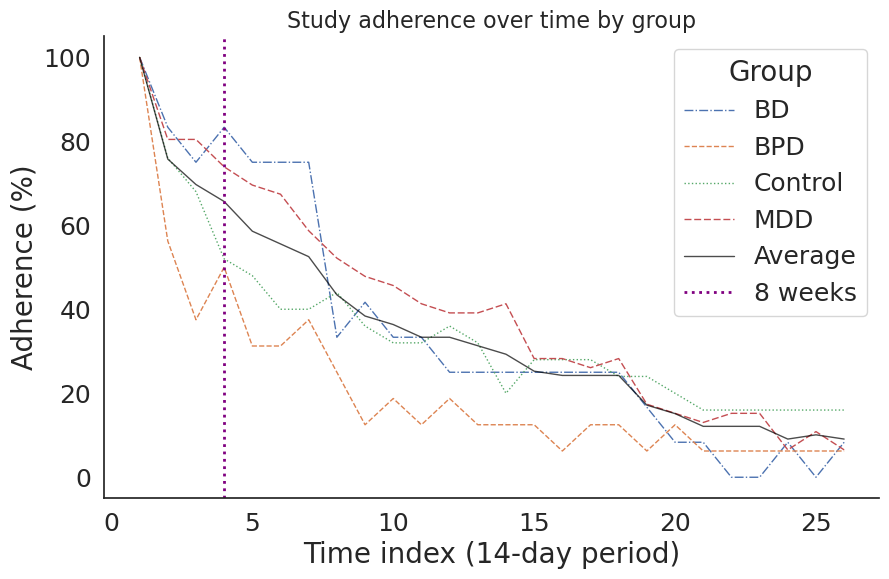

In [4]:
# Replace inf and -inf with NaN in the dataframe
result.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# Set style 
sns.set(style="white")

# Create the plot
plt.figure(figsize=(10, 6))

# Set font sizes
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

# Use Seaborn lineplot with different line styles
sns.lineplot(data=result, x=result.index, y='bd', label='BD', linestyle='-.', linewidth=1)
sns.lineplot(data=result, x=result.index, y='bpd', label='BPD', linestyle='--', linewidth=1)
sns.lineplot(data=result, x=result.index, y='control', label='Control', linestyle=':', linewidth=1)
sns.lineplot(data=result, x=result.index, y='mdd', label='MDD', linestyle=(0, (5, 2)), linewidth=1)
sns.lineplot(data=result, x=result.index, y='total', label='Average', linestyle='-', color='black', linewidth=1, alpha=0.7)

# Removing axis spines
sns.despine(top=True, right=True)

# Adding a vertical line at index 4, corresponding to 2 months 
plt.axvline(x=4, color='purple', linestyle=':', linewidth=2, label='8 weeks')

# Removing grid
plt.grid(False)

# Adding labels and title
plt.xlabel('Time index (14-day period)', fontsize=20)
plt.ylabel('Adherence (%)', fontsize=20)
plt.title('Study adherence over time by group',fontsize=16)

# Adding legend 
legend = plt.legend(title='Group')
plt.setp(legend.get_title(), fontsize=20)  # Set font size of the legend title

# Save the plot as an image
plt.savefig(OUTPUT_DIR / "PHQ9_adherence.png", dpi=300)

# Show the plot
plt.show()


---

## 3) Prepare the dataframe for survival analysis 

In [5]:
# Group by 'user' and find the maximum 'idx' for each user
max_idx_per_user = df.groupby("user")["idx"].max()

# Max_idx_per_user now contains the maximum index for each user. 
# Merge with the original DataFrame to get the 'group' column
merged_df = pd.merge(max_idx_per_user, df, on=["user", "idx"], how="left")

# Drop duplicates to retain only the unique combination for each user
final_df = merged_df.drop_duplicates(subset=["user"])

# Add a new column 'event_occurred' based on the 'idx' column
final_df["event_occurred"] = final_df["idx"].apply(lambda x: 1 if x < 26 else 0)

# Rename the 'idx' as 'time_to_event'
final_df.rename(columns={"idx": "time_to_event"}, inplace=True)

---

## 4) Run the survival analysis

### 4.1) Kaplan-Meier estimates

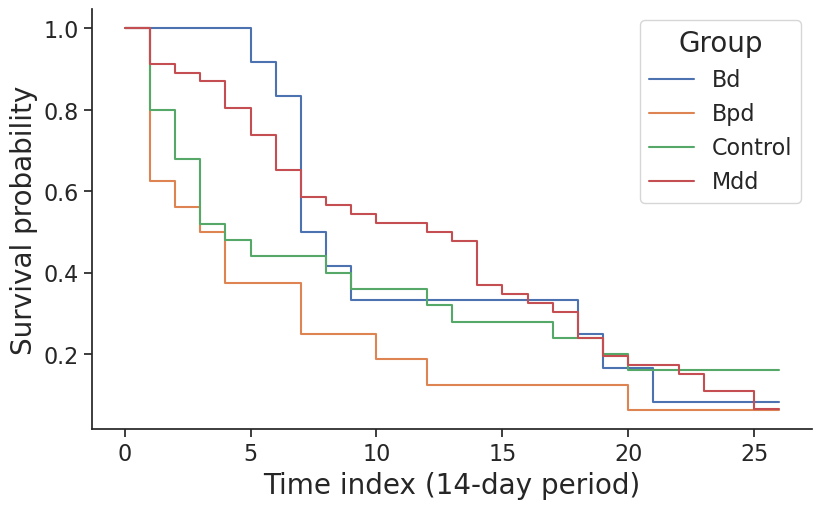

In [6]:
kmf = KaplanMeierFitter()

# Set font sizes for the plot (comparable with previous plots)
plt.rc('font', size=16)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=20)

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))

# Group renaming (mapping CONTROL -> Control)
group_mapping = {"CONTROL": "Control"}

# Iterate over each group in alphabetical order
for group in sorted(final_df["group"].unique()):  
    group_df = final_df[final_df["group"] == group]
    group_name = group_mapping.get(group, group)

    # Fit the model
    kmf.fit(
        durations=group_df["time_to_event"],
        event_observed=group_df["event_occurred"],
        label=str(group_name).capitalize(),
    )

    # Plot survival function (no shading)
    kmf.plot_survival_function(ax=ax, ci_show=False)

# Keep only left & bottom spines (like your other plots)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(left=True, bottom=True)

# Remove grid
ax.grid(False)

# Labels
plt.xlabel("Time index (14-day period)", fontsize=20)
plt.ylabel("Survival probability", fontsize=20)

# Legend with title
legend = ax.legend(title='Group')
plt.setp(legend.get_title(), fontsize=20)

# Adjust margins
plt.subplots_adjust(left=0.18, bottom=0.18)

# Save figure
plt.savefig(OUTPUT_DIR / "PHQ9_survival.png", dpi=300)

# Show the plot
plt.show()


### 4.2) Log-rank test

In [7]:
# Perform global log-rank test across all groups
results = multivariate_logrank_test(
    event_durations=final_df["time_to_event"],
    event_observed=final_df["event_occurred"],
    groups=final_df["group"],
)

# Print the test results, test statistic, p-values
print(results.summary)

   test_statistic         p  -log2(p)
0        4.599751  0.203563   2.29645


In [8]:
# Generate all unique pairwise group combinations for post-hoc comparisons
group_pairs = list(itertools.combinations(final_df["group"].unique(), 2))
comparison_results = []

# Loop over each group pair and perform a two-sample log-rank test
for group1, group2 in group_pairs:
    data_group1 = final_df[final_df["group"] == group1]
    data_group2 = final_df[final_df["group"] == group2]

    result = logrank_test(
        data_group1["time_to_event"],
        data_group2["time_to_event"],
        event_observed_A=data_group1["event_occurred"],
        event_observed_B=data_group2["event_occurred"],
    )

    # Store the comparison result with raw p-value
    comparison_results.append(
        {"group_1": group1, "group_2": group2, "p-val": result.p_value}
    )

In [9]:
# Extract the original p-values
p_values = [result["p-val"] for result in comparison_results]

# Apply Benjamini-Hochberg FDR correction
p_adjusted = multipletests(p_values, alpha=0.05, method="fdr_bh")[1]

# Update the list with adjusted p-values
for result, adj_p in zip(comparison_results, p_adjusted):
    result["adjusted p-val"] = adj_p

In [10]:
# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(comparison_results)
results_df

,group_1,group_2,p-val,adjusted p-val
0,control,bpd,0.273597,0.547194
1,control,mdd,0.605462,0.728505
2,control,bd,0.607088,0.728505
3,bpd,mdd,0.031532,0.189193
4,bpd,bd,0.121748,0.365245
5,mdd,bd,0.996095,0.996095


---

## References
<a id="ref1"></a> [1]. Aledavood, T., Luong, N., Baryshnikov, I., Darst, R., Heikkilä, R., Holmén, J., ... & Isometsä, E. (2025). Multimodal digital phenotyping study in patients with major depressive episodes and healthy controls (mobile monitoring of mood): Observational longitudinal study. JMIR Mental Health, 12, e63622 [doi: 10.2196/63622](https://doi.org/10.2196/63622).
